In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import yaml
import time

In [2]:
sites_yaml = '../../sites/TFBS/scripts/10000_unfiltered_sites_CIS_BP_v2.yaml'

data_dir = '../../GC_and_mappability_content/GC_and_mappability_snakemake/results'

stats_GC_corrected_path = '../GC_correction/files/exclusion_filtered.GC_corrected.tsv'
stats_uncorrected_path = '../GC_correction/files/exclusion_filtered.uncorrected.tsv'

In [3]:
center_columns = np.arange(-30,30).astype(str)
flanking_columns = np.append(np.arange(-1000,-30).astype(str),np.arange(30,1000).astype(str))


In [4]:
#import RMSE data
RMSE_GC_corrected = pd.read_csv(stats_GC_corrected_path, sep='\t')
RMSE_GC_corrected = RMSE_GC_corrected.set_index(['site_name'])[['lin-reg-RMSE_central_coverage']]
RMSE_uncorrected = pd.read_csv(stats_uncorrected_path, sep='\t')
RMSE_uncorrected = RMSE_uncorrected.set_index(['site_name'])[['lin-reg-RMSE_central_coverage']]
RMSE = RMSE_uncorrected.merge(RMSE_GC_corrected, left_index=True, right_index = True, suffixes = ['_uncorrected','_GC_corrected'])
RMSE['RMSE_difference'] = RMSE['lin-reg-RMSE_central_coverage_uncorrected']-RMSE['lin-reg-RMSE_central_coverage_GC_corrected']

In [5]:
#import data
with open(sites_yaml, 'r') as f:
    sites = yaml.safe_load(f)
sites = sites['site_lists']
sites = list(sites.keys())

In [6]:
#this takes 12 minutes to run
results_dict = {}
start_time = time.time()
for i,site_name in enumerate(sites):
    path = data_dir+'/'+site_name+'.smoothed_GC_content.tsv'
    current = pd.read_csv(path, sep='\t')
    #current['unique_ID'] = current['unique_ID']+'_'+site_name
    current = current.set_index('unique_ID')
    center_value = current[center_columns].mean().mean()
    flanking_value = current[flanking_columns].mean().mean()
    difference = center_value-flanking_value
    results_dict[site_name] = {}
    results_dict[site_name]['center'] = center_value
    results_dict[site_name]['flanking'] = flanking_value
    results_dict[site_name]['difference'] = difference
    
    if i%20==0:
        print(i,site_name, np.round(time.time()-start_time))

results = pd.DataFrame(results_dict)   

0 AHR.hg38.10000 2.0
20 BPTF.hg38.10000 57.0
40 EBF1.hg38.10000 105.0
60 ETV2.hg38.10000 152.0
80 FOXP3.hg38.10000 201.0
100 HIF3A.hg38.10000 252.0
120 IRF1.hg38.10000 301.0
140 LYL1.hg38.10000 351.0
160 MXI1.hg38.10000 404.0
180 NFIL3.hg38.10000 449.0
200 OTX2.hg38.10000 495.0
220 PPARD.hg38.10000 540.0
240 RXRA.hg38.10000 587.0
260 SP2.hg38.10000 631.0
280 TBX21.hg38.10000 675.0
300 TLX1.hg38.10000 718.0
320 ZBTB26.hg38.10000 761.0
340 ZNF18.hg38.10000 803.0
360 ZNF467.hg38.10000 846.0


In [7]:
#merge RMSE results
RMSE = RMSE.merge(results.T[['difference']],left_index=True, right_index = True)

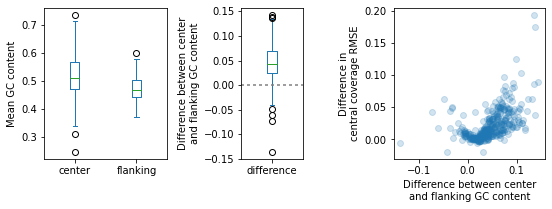

In [8]:
fig = plt.figure(figsize = (8,3))
spec = gridspec.GridSpec(ncols=3, nrows=1,
                         width_ratios=[2,1,3])

ax1 = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])
ax3 = fig.add_subplot(spec[2])

#plot center and flanking
results.T[['center','flanking']].plot.box(ax = ax1)
ax1.set_ylabel('Mean GC content')

#plot difference between center and flanking
results.T[['difference']].plot.box(ax = ax2)
ax2.axhline(0,dashes = [2,2], color = 'tab:grey')
ax2.set_ylabel('Difference between center\nand flanking GC content')

#scatter against RMSE
ax3.scatter(RMSE['difference'],RMSE['RMSE_difference'],alpha = 0.2)

ax3.set_xlabel('Difference between center\nand flanking GC content')
ax3.set_ylabel('Difference in\ncentral coverage RMSE')

ax3.set_aspect(1.0/ax3.get_data_ratio(), adjustable='box')
fig.tight_layout()
fig.savefig('plots/GC_content_at_sites.pdf')

In [9]:
results.T[['center','flanking','difference']].median()

center        0.511105
flanking      0.468040
difference    0.042443
dtype: float64

In [10]:
#factors with higher GC content at the site than flanking region
sum(results.T['difference']>0)

344

In [14]:
results.T.reset_index().rename(columns = {'index':'site_name'}).to_csv('files/S1_GC_content_around_TFBS.tsv',sep='\t', index=False)